In [ ]:
if 'google.colab' in str(get_ipython()):
    !rm -rf RL
    !git clone https://github.com/shamrous/RL.git
    import sys
    sys.path.append('/content/RL/Bandit')

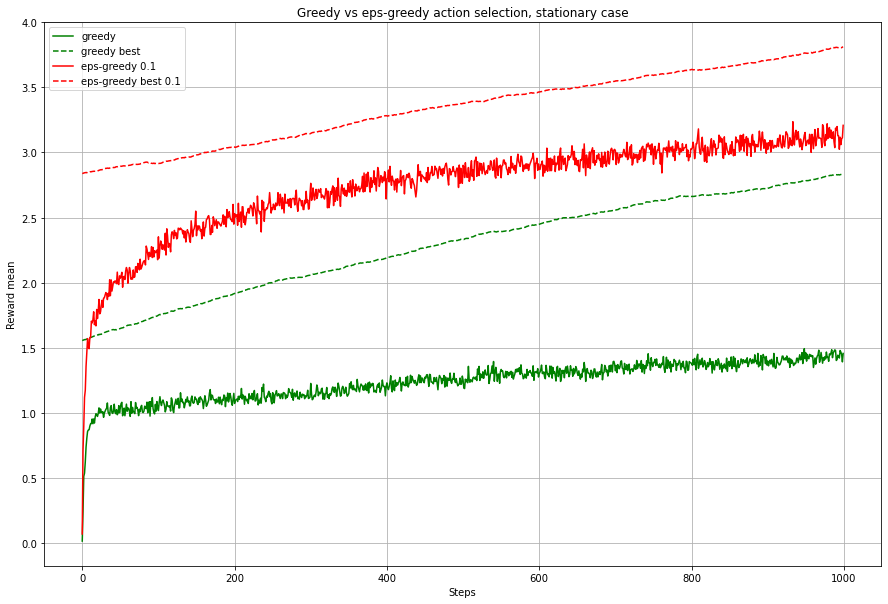

In [1]:
from typing import Callable, List
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from Bandit import *

In [2]:
def create_bandits(bandits: int, arms: int, mean: float, stdev: float) -> List[Bandit]:
    all_bandits = []
    for _ in range(bandits):
        all_bandits.append(Bandit(arms, mean, stdev))
    return all_bandits

def calculate_rewards_mean_per_step(bandits, steps):
    all_rewards = np.zeros((len(bandits), steps))
    all_best_rewards = np.zeros((len(bandits), steps))
    for i, bandit in enumerate(bandits):
        all_rewards[i], all_best_rewards[i] = bandit.play_many(steps)
    # Get mean across all bandits for each step
    steps_mean = np.mean(all_rewards, axis=0)
    step_mean_best = np.mean(all_best_rewards, axis=0)
    return steps_mean, step_mean_best

def draw_plot(title):
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Reward mean")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
n_bandits = 200
steps = 500
arms = 10
mean = 0.0
stdev = 1.0

# Use same problems for all tests
bandits = create_bandits(n_bandits, arms, mean, stdev)

Run stationary eps-greedy bandit with step size = 1/n, for different values of eps.
The greedy method improved slightly faster than the other methods at the very beginning, but then leveled
of at a lower level. The greedy method performed significantly worse in the long run because it often got stuck performing suboptimal actions.
The eps-greedy methods eventually performed better because they continued to explore and to improve their chances of recognizing
the optimal action. 

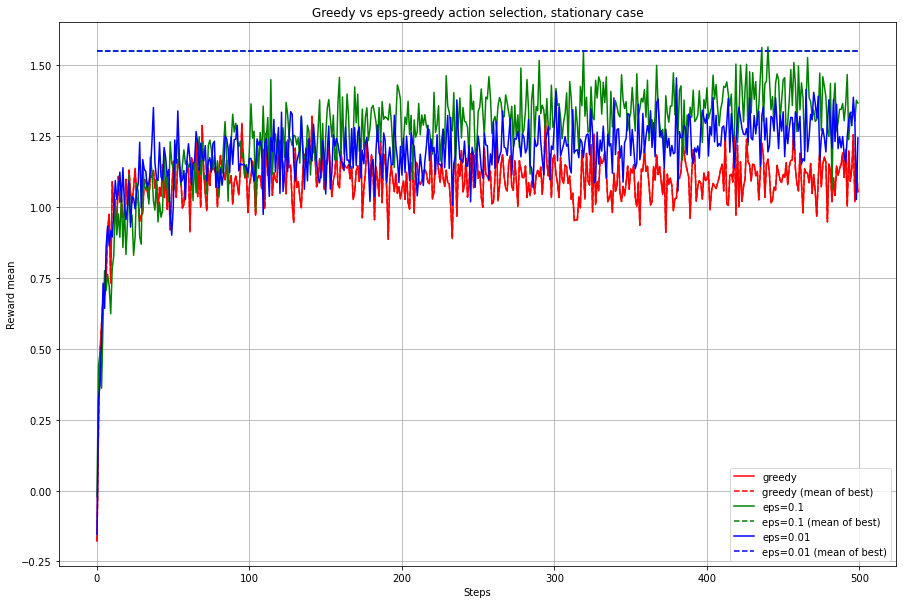

In [4]:
fn_eps_greedy = partial(Bandit.configure, 
                    step_size = "sample_average", step_size_params = None,
                    step_updater = "inc_to_error_stationary", step_updater_params = None,
                    init_Q = 0)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "greedy", action_selector_params = None)    
steps_mean_greedy, steps_mean_greedy_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "eps_greedy", action_selector_params = {'eps':0.1})    
steps_mean_greedy_eps_01, steps_mean_greedy_eps_01_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "eps_greedy", action_selector_params = {'eps':0.01})    
steps_mean_greedy_eps_001, steps_mean_greedy_eps_001_best = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_greedy, 'r', label="greedy")
plt.plot(np.arange(steps), steps_mean_greedy_best, 'r--', label="greedy (mean of best)")
plt.plot(np.arange(steps), steps_mean_greedy_eps_01, 'g', label="eps=0.1")
plt.plot(np.arange(steps), steps_mean_greedy_eps_01_best, 'g--', label="eps=0.1 (mean of best)")
plt.plot(np.arange(steps), steps_mean_greedy_eps_001, 'b', label="eps=0.01")
plt.plot(np.arange(steps), steps_mean_greedy_eps_001_best, 'b--', label="eps=0.01 (mean of best)")
draw_plot("Greedy vs eps-greedy action selection, stationary case")


Run non-stationary eps-greedy bandit with step size = 0.1
This example demonstrates that constant estimates never completely converge but
continue to vary in response to the most recently received rewards. As we mentioned
above, this is actually desirable in a nonstationary environment, and problems that are
effectively nonstationary are the most common in reinforcement learning.

In [ ]:
def const_step(alpha):
    def step(t, action):
        return alpha
    return step

n_bandits = 2000
steps = 20000
arms = 10
mean = 0
stdev = 1
all_eps = [0.1]
plot_title = "Non-stationary with constant step size"
stationary = False
fn_step_size = const_step(0.1)

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size)


Run non-stationary eps-greedy bandit with step size = 1/n
Step sizes that guarantee convergeness often converge very slowly or need considerable tuning in order to 
obtain a satisfactory convergence rate. 
Although sequences of step-size parameters that meet these convergence conditions are often used
in theoretical work, they are seldom used in applications and empirical research.

In [ ]:
n_bandits = 2000
steps = 20000
arms = 10
mean = 0
stdev = 1
all_eps = [0.1]
plot_title = "Non-stationary with average sample step size (1/n)"
stationary = False
fn_step_size = None # 1/n is default

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size)



**Run stationary eps-greedy bandit with sample-average step size 1/n and optimistic initial value of Q.**
All the methods we have discussed so far are dependent to some extent on the initial
action-value estimates Q1. In the language of statistics, these methods are biased
by their initial estimates. For the sample-average methods, the bias disappears once all
actions have been selected at least once, but for methods with constant, the bias is
permanent, though decreasing over time. Initial action values can also be used as a simple way to encourage exploration.
Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to
other actions, being “disappointed” with the rewards it is receiving. The result is that all
actions are tried several times before the value estimates converge. The system does a
fair amount of exploration even if greedy actions are selected all the time.
h time. We call this technique for encouraging exploration optimistic initial values. We regard it as
a simple trick that can be quite effective on stationary problems, but it is far from
being a generally useful approach to encouraging exploration. For example, it is not
well suited to nonstationary problems because its drive for exploration is inherently temporary.

In [ ]:
n_bandits = 2000
steps = 10000
arms = 10
mean = 0
stdev = 1
all_eps = [0, 0.1]
plot_title = "Stationary with sample-average step size 1/n, and optimistic initial values"
stationary = True
fn_step_size = None
initQ = 5.0

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size, initQ)

**Unbiased Constant-Step-Size Trick.**

Sample
averages are not a completely satisfactory solution because they may perform poorly
on nonstationary problems. Is it possible to avoid the bias of constant step sizes while
retaining their advantages on nonstationary problems

In [ ]:
def const_step_unbiased(alpha, arms):
    o = np.zeros(arms)
    def step(t, action):
        o_n = o[action] + alpha * (1 - o[action])
        o[action] = o_n
        return alpha/o_n
    return step

n_bandits = 2000
steps = 20000
arms = 10
mean = 0
stdev = 1
all_eps = [0.1]
plot_title = "Non-stationary with const step size and un-biased step"
stationary = False
fn_step_size = const_step_unbiased(0.1, arms)

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size)